## Load the corpus

We use a labeled Movie Review Dataset to implement a simple supervised machine learning approach. The dataset contains 5,331 positive and 5,331 negative processed sentences from Rotten Tomatoes movie reviews.
Our goal is to train a classifier that can predict whether a sentence is positive or negative.

This data was first used in Bo Pang and Lillian Lee, ``Seeing stars: Exploiting class relationships for sentiment categorization with respect to rating scales.'', Proceedings of the ACL, 2005. Please find more information on the dataset here.
https://huggingface.co/datasets/rotten_tomatoes

Data labeling: "the movie-review “snippets” (a striking extract usually one sentence long) downloaded from www.rottentomatoes.com; each
snippet was labeled with its source review’s label
(positive or negative) as provided by Rotten Tomatoes." (Pang & Lee, 2005) p.119)

In [1]:
# !pip install scikit-learn nltk

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk


In [2]:


# Load the dataset with specified encoding
url = "https://raw.githubusercontent.com/fabiennelind/text-as-data-in-R/main/data/rotten_tomatoes.csv"
reviews = pd.read_csv(url, encoding='latin1')  # Use 'latin1' encoding for non-UTF-8 characters

# Inspect the data
print(reviews.head())  # Display the first few rows
print(reviews.info())  # General information about the dataset


                                               value  polarity
0  the rock is destined to be the 21st century's ...  positive
1  the gorgeously elaborate continuation of " the...  positive
2                     effective but too-tepid biopic  positive
3  if you sometimes like to go to the movies to h...  positive
4  emerges as something rare , an issue movie tha...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   value     10662 non-null  object
 1   polarity  10662 non-null  object
dtypes: object(2)
memory usage: 166.7+ KB
None


# Inspecting the data

In [3]:
# View column names
print(reviews.columns)

# Rename the column 'value' to 'text'
reviews.rename(columns={'value': 'text'}, inplace=True)

# Check the class of the 'text' column
print(type(reviews['text']))

# Check the distribution of the outcome variable ('polarity')
print(reviews['polarity'].value_counts())

# Check the class of the 'polarity' column
print(type(reviews['polarity']))


Index(['value', 'polarity'], dtype='object')
<class 'pandas.core.series.Series'>
polarity
positive    5331
negative    5331
Name: count, dtype: int64
<class 'pandas.core.series.Series'>


In [7]:
first, second, third = 1, 2, 3

In [9]:
first

1

In [10]:
second

2

In [11]:
# Download required NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Create an ID column for each document
reviews['id_numeric'] = range(1, len(reviews) + 1)

# Split data into training and test sets (80% train, 20% test)
np.random.seed(657)  # Set random seed for reproducibility
id_train, id_test = train_test_split(reviews['id_numeric'], test_size=0.2, random_state=657)

# Tokenization, stopword removal, and stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation and numbers
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Apply stemming
    return tokens

# Apply preprocessing to the 'text' column
reviews['processed_text'] = reviews['text'].apply(preprocess)

# Convert processed text into a document-term matrix (DFM)
vectorizer = CountVectorizer(analyzer=lambda x: x)  # Pass pre-tokenized text
dfm_reviews = vectorizer.fit_transform(reviews['processed_text'])

# Trim the DFM by minimum document frequency (min_docfreq=2)
min_docfreq = 2
dfm_trimmed = dfm_reviews[:, np.array((dfm_reviews > 0).sum(axis=0)).flatten() >= min_docfreq]

# Split the DFM into training and test sets
train_mask = reviews['id_numeric'].isin(id_train)
test_mask = reviews['id_numeric'].isin(id_test)

dfm_train = dfm_trimmed[train_mask, :]
dfm_test = dfm_trimmed[test_mask, :]

# Summary of results
print("DFM Shape (Full):", dfm_reviews.shape)
print("DFM Shape (Trimmed):", dfm_trimmed.shape)
print("Training Set Shape:", dfm_train.shape)
print("Test Set Shape:", dfm_test.shape)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/petrotolochko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/petrotolochko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/petrotolochko/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


DFM Shape (Full): (10662, 12126)
DFM Shape (Trimmed): (10662, 7241)
Training Set Shape: (8529, 7241)
Test Set Shape: (2133, 7241)



# Training


In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

# Encode the target variable (polarity) as numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(reviews.loc[train_mask, 'polarity'])
y_test = label_encoder.transform(reviews.loc[test_mask, 'polarity'])

# Create a Multinomial Naive Bayes model
# Scikit-learn's MultinomialNB uses term frequencies directly
model_nb = MultinomialNB()

# model_nb = MultinomialNB(class_prior=[0.5, 0.5])  # Example: Equal priors


# Fit the model on the training data
model_nb.fit(dfm_train, y_train)

# Model summary
print("Classes:", label_encoder.classes_)
print("Class Log Prior (from docfreq):", model_nb.class_log_prior_)


Classes: ['negative' 'positive']
Class Log Prior (from docfreq): [-0.69209251 -0.69420296]


In [14]:
np.log(0.5)

-0.6931471805599453

In [15]:
from sklearn.svm import LinearSVC

# Encode the target variable (polarity) as numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(reviews.loc[train_mask, 'polarity'])
y_test = label_encoder.transform(reviews.loc[test_mask, 'polarity'])

# Create and train the SVM model
model_svm = LinearSVC()  # Linear kernel SVM suitable for high-dimensional sparse data
model_svm.fit(dfm_train, y_train)

# Model summary
print("Classes:", label_encoder.classes_)

Classes: ['negative' 'positive']


# Predict for the test set (NB)


In [16]:
# Predict for the test set using Naive Bayes
y_pred_nb = model_nb.predict(dfm_test)

# Decode predictions back to original labels
y_pred_nb_decoded = label_encoder.inverse_transform(y_pred_nb)

# Summary of predictions
print("Naive Bayes Predictions Summary:")
print(pd.Series(y_pred_nb_decoded).value_counts())


Naive Bayes Predictions Summary:
negative    1086
positive    1047
Name: count, dtype: int64


In [17]:
# Summary of the Naive Bayes model
print("Naive Bayes Model Class Log Priors:")
print(model_nb.class_log_prior_)

print("Naive Bayes Model Feature Log Probabilities:")
print(model_nb.feature_log_prob_)  # Log probabilities of features per class


Naive Bayes Model Class Log Priors:
[-0.69209251 -0.69420296]
Naive Bayes Model Feature Log Probabilities:
[[ -9.38294824  -8.82333245 -10.07609542 ... -10.07609542  -9.15980469
  -10.7692426 ]
 [-10.79677574  -9.41048138 -10.10362856 ... -10.10362856  -9.41048138
   -9.69816345]]


# Predict for test set (SVM)

In [18]:
# Predict for the test set using SVM
y_pred_svm = model_svm.predict(dfm_test)

# Decode predictions back to original labels
y_pred_svm_decoded = label_encoder.inverse_transform(y_pred_svm)

# Summary of predictions
print("SVM Predictions Summary:")
print(pd.Series(y_pred_svm_decoded).value_counts())


SVM Predictions Summary:
negative    1104
positive    1029
Name: count, dtype: int64


# Precision / Recall / F1 Scores

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$


$$
\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$


$$
\text{Macro F1-Score} = \frac{1}{C} \sum_{i=1}^{C} F_1^i
$$



In [19]:
# Assume y_test is the ground truth and predictions are already made
# y_test: True labels for the test set
# y_pred_nb: Predictions from Naive Bayes
# y_pred_svm: Predictions from SVM

def calculate_metrics(y_true, y_pred):
    """
    Function to calculate precision, recall, and F1-score manually.
    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
    Returns:
        dict: Metrics for each class.
    """
    # Get unique classes
    classes = set(y_true)
    metrics = {}

    for cls in classes:
        # True Positives (TP)
        tp = sum((y_pred[i] == cls) and (y_true[i] == cls) for i in range(len(y_true)))
        # False Positives (FP)
        fp = sum((y_pred[i] == cls) and (y_true[i] != cls) for i in range(len(y_true)))
        # False Negatives (FN)
        fn = sum((y_pred[i] != cls) and (y_true[i] == cls) for i in range(len(y_true)))

        # Precision, Recall, F1-Score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Store metrics for the class
        metrics[cls] = {
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score
        }

    return metrics


In [20]:

# Decode y_test to original labels (if necessary)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Decode predictions to original labels
y_pred_nb_decoded = label_encoder.inverse_transform(y_pred_nb)
y_pred_svm_decoded = label_encoder.inverse_transform(y_pred_svm)

# Calculate metrics for Naive Bayes
nb_metrics = calculate_metrics(y_test_decoded, y_pred_nb_decoded)

# Calculate metrics for SVM
svm_metrics = calculate_metrics(y_test_decoded, y_pred_svm_decoded)

# Display results
print("Metrics for Naive Bayes:")
for cls, scores in nb_metrics.items():
    print(f"Class: {cls}")
    print(f"  Precision: {scores['Precision']:.2f}")
    print(f"  Recall: {scores['Recall']:.2f}")
    print(f"  F1-Score: {scores['F1-Score']:.2f}")

print("\nMetrics for SVM:")
for cls, scores in svm_metrics.items():
    print(f"Class: {cls}")
    print(f"  Precision: {scores['Precision']:.2f}")
    print(f"  Recall: {scores['Recall']:.2f}")
    print(f"  F1-Score: {scores['F1-Score']:.2f}")

Metrics for Naive Bayes:
Class: positive
  Precision: 0.77
  Recall: 0.76
  F1-Score: 0.77
Class: negative
  Precision: 0.76
  Recall: 0.78
  F1-Score: 0.77

Metrics for SVM:
Class: positive
  Precision: 0.75
  Recall: 0.72
  F1-Score: 0.74
Class: negative
  Precision: 0.73
  Recall: 0.76
  F1-Score: 0.74


# Accuracy

In [23]:
def compute_accuracy(y_true, y_pred):
    """
    Compute accuracy as the ratio of correctly predicted instances to the total instances.
    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
    Returns:
        float: Accuracy value.
    """
    # Create a confusion matrix
    conf_mat = pd.crosstab(pd.Series(y_true, name="Actual"), pd.Series(y_pred, name="Predicted"))
    
    # Extract diagonal (correctly predicted instances)
    correct_predictions = conf_mat.to_numpy().diagonal().sum()
    total_instances = conf_mat.to_numpy().sum()
    
    # Calculate accuracy
    accuracy = correct_predictions / total_instances
    return accuracy

# Example usage with Naive Bayes predictions
accuracy_nb = compute_accuracy(y_test_decoded, y_pred_nb_decoded)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")

# Example usage with SVM predictions
accuracy_svm = compute_accuracy(y_test_decoded, y_pred_svm_decoded)
print(f"SVM Accuracy: {accuracy_svm:.2f}")


Naive Bayes Accuracy: 0.77
SVM Accuracy: 0.74


In [24]:
!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

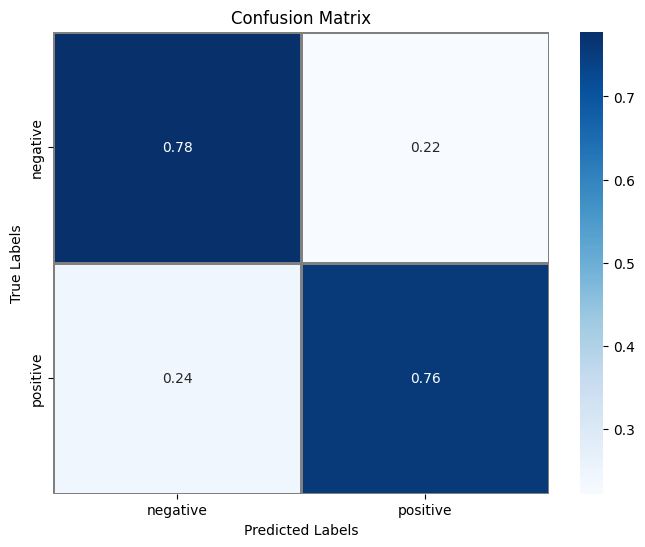

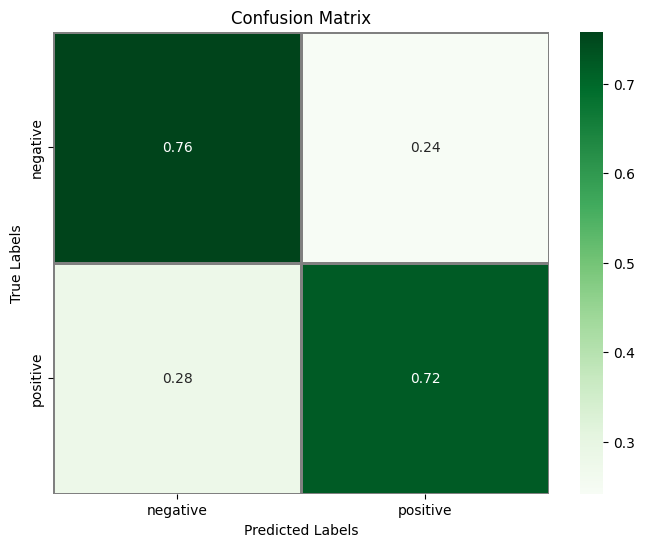

In [25]:


def plot_confusion_matrix(y_true, y_pred, color="Blues"):
    """
    Plot a confusion matrix as a heatmap.
    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
        color (str): Color scheme for the heatmap.
    Returns:
        None
    """
    # Create a confusion matrix
    conf_mat = pd.crosstab(pd.Series(y_true, name="Actual"), pd.Series(y_pred, name="Predicted"))
    
    # Normalize rows to proportions
    conf_mat_normalized = conf_mat.div(conf_mat.sum(axis=1), axis=0)
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat_normalized, annot=True, fmt=".2f", cmap=color, cbar=True, linewidths=1, linecolor="gray")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Example usage with Naive Bayes predictions
plot_confusion_matrix(y_test_decoded, y_pred_nb_decoded, color="Blues")

# Example usage with SVM predictions
plot_confusion_matrix(y_test_decoded, y_pred_svm_decoded, color="Greens")


# K-Fold Cross-Validation

In [27]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

def k_fold_cross_validation(model, X, y, k=5):
    """
    Perform k-fold cross-validation.
    Args:
        model: Machine learning model (e.g., Naive Bayes or SVM).
        X: Document-term matrix (features).
        y: Target labels.
        k: Number of folds for cross-validation.
    Returns:
        dict: Average precision, recall, F1-score, and accuracy across all folds.
    """
    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Initialize metrics
    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracy_scores = []
    
    for train_index, test_index in kf.split(X):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Compute metrics
        tp = sum((y_pred == y_test) & (y_test == 1))  # True positives
        fp = sum((y_pred == 1) & (y_test == 0))       # False positives
        fn = sum((y_pred == 0) & (y_test == 1))       # False negatives
        tn = sum((y_pred == y_test) & (y_test == 0))  # True negatives
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        # Store metrics for this fold
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
    
    # Compute average metrics across all folds
    return {
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores),
        "F1-Score": np.mean(f1_scores),
        "Accuracy": np.mean(accuracy_scores)
    }

# Example Usage
# Encode labels (if not already numeric)
y_encoded = label_encoder.transform(reviews['polarity'])

# Naive Bayes
nb_model = MultinomialNB()
nb_metrics = k_fold_cross_validation(nb_model, dfm_reviews, y_encoded, k=20)
print("Naive Bayes Cross-Validation Metrics:", nb_metrics)

# SVM
svm_model = LinearSVC()
svm_metrics = k_fold_cross_validation(svm_model, dfm_reviews, y_encoded, k=20)
print("SVM Cross-Validation Metrics:", svm_metrics)


Naive Bayes Cross-Validation Metrics: {'Precision': 0.7709636782471435, 'Recall': 0.7709088885849771, 'F1-Score': 0.7707378068649006, 'Accuracy': 0.7710572267779723}
SVM Cross-Validation Metrics: {'Precision': 0.7310225838662151, 'Recall': 0.7377136919334133, 'F1-Score': 0.7340645022291323, 'Accuracy': 0.73363478578606}


# Area Under PR-Curve

In [34]:
import numpy as np

def precision_recall_curve(y_true, y_scores):
    """
    Compute precision-recall curve points.
    Args:
        y_true (list or np.array): True binary labels (0 or 1).
        y_scores (list or np.array): Predicted scores or probabilities.
    Returns:
        tuple: Precision, recall, and thresholds.
    """
    # Sort by descending scores
    sorted_indices = np.argsort(-y_scores)
    y_true_sorted = np.array(y_true)[sorted_indices]
    y_scores_sorted = np.array(y_scores)[sorted_indices]
    
    # Initialize variables
    tp = 0
    fp = 0
    fn = sum(y_true)  # All positives initially not predicted
    precision = []
    recall = []
    thresholds = []

    # Iterate over sorted scores
    for i, score in enumerate(y_scores_sorted):
        if y_true_sorted[i] == 1:
            tp += 1  # True positive
            fn -= 1  # One less false negative
        else:
            fp += 1  # False positive
        
        # Compute precision and recall
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision.append(prec)
        recall.append(rec)
        thresholds.append(score)
    
    return np.array(precision), np.array(recall), np.array(thresholds)

def auc_pr(recall, precision):
    """
    Compute the area under the precision-recall curve.
    Args:
        recall (np.array): Recall values.
        precision (np.array): Precision values.
    Returns:
        float: Area under the curve.
    """
    return np.trapeze(precision, recall)  # Use the trapezoidal rule


In [35]:
# Get probabilities or decision scores from models
# Naive Bayes provides probabilities
y_scores_nb = model_nb.predict_proba(dfm_test)[:, 1]  # Probabilities for the positive class
y_true = y_test  # Ground truth labels (binary: 0 or 1)

# SVM provides decision function scores (not probabilities)
y_scores_svm = model_svm.decision_function(dfm_test)  # Decision scores

# Compute Precision-Recall curve for Naive Bayes
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true, y_scores_nb)
auc_pr_nb = auc_pr(recall_nb, precision_nb)
print(f"Naive Bayes AUC-PR: {auc_pr_nb:.2f}")

# Compute Precision-Recall curve for SVM
precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_true, y_scores_svm)
auc_pr_svm = auc_pr(recall_svm, precision_svm)
print(f"SVM AUC-PR: {auc_pr_svm:.2f}")

AttributeError: module 'numpy' has no attribute 'trapeze'

In [29]:
import matplotlib.pyplot as plt

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_nb, precision_nb, label=f"Naive Bayes (AUC-PR: {auc_pr_nb:.2f})")
plt.plot(recall_svm, precision_svm, label=f"SVM (AUC-PR: {auc_pr_svm:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

NameError: name 'recall_nb' is not defined

<Figure size 800x600 with 0 Axes>

# Base Python NB Classifier

In [36]:
from collections import defaultdict
import math

class NaiveBayesClassifier:
    def __init__(self):
        self.classes = set()  # Set of unique classes
        self.word_counts = defaultdict(lambda: defaultdict(int))  # Word frequency per class
        self.class_counts = defaultdict(int)  # Total word count per class
        self.total_docs = 0  # Total number of documents
        self.doc_counts = defaultdict(int)  # Document count per class
    
    def train(self, X, y):
        """
        Train the Naive Bayes classifier.
        
        Parameters:
            X (list of lists): List of documents, each represented as a list of words.
            y (list): Corresponding class labels for each document.
        """
        self.total_docs = len(y)
        self.classes = set(y)
        
        for text, label in zip(X, y):
            self.doc_counts[label] += 1
            for word in text:
                self.word_counts[label][word] += 1
                self.class_counts[label] += 1
    
    def predict(self, text):
        """
        Predict the class for a given text.
        
        Parameters:
            text (list): A document represented as a list of words.
        
        Returns:
            str: The predicted class label.
        """
        log_probs = {}
        total_words = sum(self.class_counts.values())
        
        for c in self.classes:
            # Log of the prior probability P(Class)
            log_prior = math.log(self.doc_counts[c] / self.total_docs)
            
            # Log of the likelihood P(Text|Class)
            log_likelihood = 0
            for word in text:
                word_count = self.word_counts[c][word] + 1  # Add-1 smoothing
                class_word_total = self.class_counts[c] + total_words  # Total words in class + smoothing
                log_likelihood += math.log(word_count / class_word_total)
            
            log_probs[c] = log_prior + log_likelihood
        
        # Return the class with the highest posterior probability
        return max(log_probs, key=log_probs.get)


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import nltk

# Assuming reviews['text'] contains the text and reviews['polarity'] contains the labels
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Step 1: Preprocess the text
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Tokenize, remove punctuation and stop words, and lowercase
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Keep only alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Apply preprocessing
reviews['processed_text'] = reviews['text'].apply(preprocess)

# Step 2: Split the data into training and testing sets
X = reviews['processed_text'].tolist()  # List of tokenized documents
y = reviews['polarity'].tolist()        # List of labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize and train the classifier
nb_classifier = NaiveBayesClassifier()
nb_classifier.train(X_train, y_train)

# Step 4: Make predictions
y_pred = [nb_classifier.predict(text) for text in X_test]

# Step 5: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/petrotolochko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/petrotolochko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Accuracy: 0.7585560243788092
Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.75      0.76      1071
    positive       0.75      0.77      0.76      1062

    accuracy                           0.76      2133
   macro avg       0.76      0.76      0.76      2133
weighted avg       0.76      0.76      0.76      2133

